In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures

%matplotlib inline

### Load Data


In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
print("first eight words:", words[:8], "\nnumber of total words:", len(words))


first eight words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'] 
number of total words: 32033


### Build Vocabulary


In [3]:
# build the vocabulary of characters and mappings to/from integers
vocab = sorted(list(set("".join(words))))
vocab.insert(0, ".")
vocab_idx_lookup = {s: i for i, s in enumerate(vocab)}
idx_vocab_lookup = {i: s for s, i in vocab_idx_lookup.items()}
print(idx_vocab_lookup)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
BLOCK_SIZE = 3
N_EMB_DIM = 2
HIDDEN_LAYER_SIZE = 100
VOCAB_SIZE = len(vocab)


### Build Dataset, Splits


In [5]:
def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)
        context = [0] * BLOCK_SIZE
        for ch in w + ".":
            ix = vocab_idx_lookup[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X, Y = build_dataset(words)
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
N_OBS = len(X)


torch.Size([228146, 3]) torch.Size([228146])
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Build Embeddings Look Up Table


In [6]:
C = torch.randn((VOCAB_SIZE, N_EMB_DIM))
emb = C[X]
emb.shape


torch.Size([228146, 3, 2])

In [ ]:
W1 = torch.randn((BLOCK_SIZE * N_EMB_DIM, HIDDEN_LAYER_SIZE))
b1 = torch.randn(HIDDEN_LAYER_SIZE)


In [ ]:
h = torch.tanh(emb.view(-1, BLOCK_SIZE * N_EMB_DIM) @ W1 + b1)
h

tensor([[-0.9988, -0.6376, -0.3525,  ...,  0.3158, -0.9970, -0.9482],
        [-0.9959,  0.2250, -0.6263,  ..., -0.9864, -0.9566, -0.8850],
        [-0.9995, -0.7142,  0.9704,  ...,  0.9069, -0.9988, -0.9585],
        ...,
        [-0.9931,  0.7557,  0.9079,  ...,  0.5335, -0.9183, -0.5513],
        [-0.8422,  0.9956, -0.9737,  ..., -0.9998, -0.5601, -0.9180],
        [-0.9554,  0.9738,  0.9688,  ..., -0.5873, -0.5525, -0.9361]])

In [9]:
h.shape


torch.Size([228146, 100])

In [10]:
W2 = torch.randn((HIDDEN_LAYER_SIZE, VOCAB_SIZE))
b2 = torch.randn(VOCAB_SIZE)


In [11]:
logits = h @ W2 + b2
logits.shape


torch.Size([228146, 27])

In [12]:
counts = logits.exp()


In [13]:
prob = counts / counts.sum(1, keepdims=True)
prob.shape


torch.Size([228146, 27])

In [14]:
loss = -prob[torch.arange(N_OBS), Y].log().mean()
loss


tensor(15.1488)

In [15]:
# ------------ now made respectable :) ---------------
BLOCK_SIZE = 3
N_EMB_DIM = 10
HIDDEN_LAYER_SIZE = 200
VOCAB_SIZE = len(vocab)


In [16]:
Xtr.shape, Ytr.shape  # dataset


(torch.Size([182625, 3]), torch.Size([182625]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)  # for reproducibility
C = torch.randn((VOCAB_SIZE, N_EMB_DIM), generator=g)
W1 = torch.randn((BLOCK_SIZE * N_EMB_DIM, HIDDEN_LAYER_SIZE), generator=g)
b1 = torch.randn(HIDDEN_LAYER_SIZE, generator=g)
W2 = torch.randn((HIDDEN_LAYER_SIZE, VOCAB_SIZE), generator=g)
b2 = torch.randn(VOCAB_SIZE, generator=g)
parameters = [C, W1, b1, W2, b2]


In [18]:
sum(p.nelement() for p in parameters)  # number of parameters in total


11897

In [19]:
for p in parameters:
    p.requires_grad = True


In [20]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre


In [21]:
lri = []
lossi = []
stepi = []
N_ITER = 200000
BATCH_SIZE = 32

In [ ]:
for i in range(N_ITER):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (BATCH_SIZE,))

    # forward pass
    emb = C[Xtr[ix]]  # (BATCH_SIZE, BLOCK_SIZE, N_EMB_DIM)
    h = torch.tanh(
        emb.view(-1, BLOCK_SIZE * N_EMB_DIM) @ W1 + b1
    )  # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
    logits = h @ W2 + b2  # (BATCH_SIZE, VOCAB_SIZE)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())


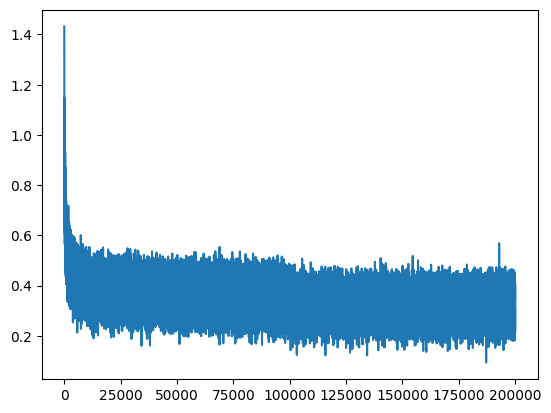

In [23]:
plt.plot(stepi, lossi)


In [ ]:
emb = C[Xtr]  # (BATCH_SIZE, BLOCK_SIZE, N_EMB_DIM)
h = torch.tanh(
    emb.view(-1, BLOCK_SIZE * N_EMB_DIM) @ W1 + b1
)  # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
logits = h @ W2 + b2  # (BATCH_SIZE, VOCAB_SIZE)
loss = F.cross_entropy(logits, Ytr)
loss


tensor(2.1291, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]  # (BATCH_SIZE, BLOCK_SIZE, N_EMB_DIM)
h = torch.tanh(
    emb.view(-1, BLOCK_SIZE * N_EMB_DIM) @ W1 + b1
)  # (BATCH_SIZE, HIDDEN_LAYER_SIZE)
logits = h @ W2 + b2  # (BATCH_SIZE, VOCAB_SIZE)
loss = F.cross_entropy(logits, Ydev)
loss


tensor(2.1621, grad_fn=<NllLossBackward0>)

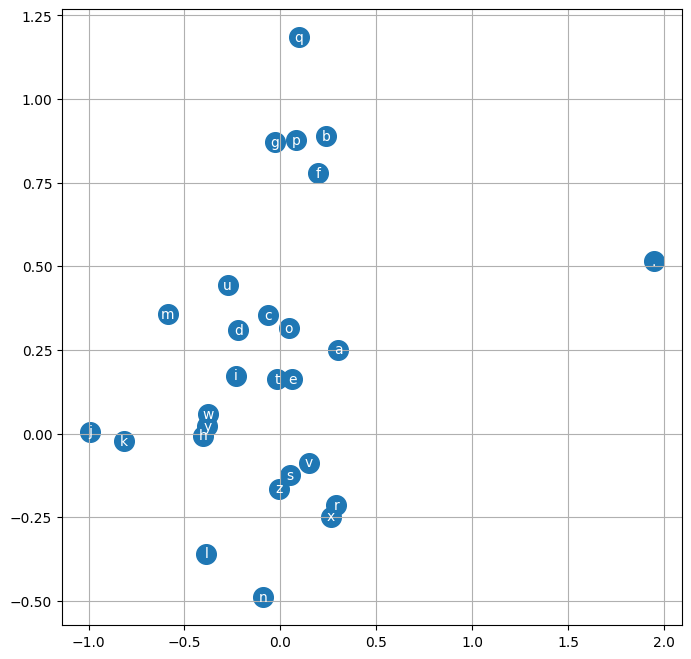

In [ ]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        idx_vocab_lookup[i],
        ha="center",
        va="center",
        color="white",
    )
plt.grid("minor")


In [ ]:
# training split, dev/validation split, test split
# 80%, 10%, 10%


In [ ]:
context = [0] * BLOCK_SIZE
C[torch.tensor([context])].shape


In [27]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * BLOCK_SIZE  # initialize with all ...
    while True:
        emb = C[torch.tensor([context])]  # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print("".join(idx_vocab_lookup[i] for i in out))


carlah.
amelle.
khyimili.
thtyn.
kanden.
jazonte.
delyah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
join.
quinn.
shon.
walianni.
watthonderrynix.
kaeklinsleen.
deco.
abette.
